# Language Classification

In [ ]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

from helper_code import *

# Helper functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
 
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.grid(b=None)

In [ ]:
def do_law_of_zipf(data):
    '''
    Convert a dictionary (keys are language, and values are lists of sentences)
    into separate Pandas DataFrames for each language, and plots log scales of
    Ranks vs Frequencies, to visualize Zipf's Law.
    '''
    languages = list(data.keys())
    words_df_dict = dict()
    
    for language in languages:
        words_df_dict[language] = pd.DataFrame()

        words = []
        for sentence in data[language]:
            words.extend(sentence.split())

        words_df_dict[language]['word'] = words
        
    for language in languages:
        freqs = words_df_dict[language]['word'].value_counts().values
        ranks = range(1, len(freqs)+1)
        plt.plot(freqs, ranks, label=language)

    plt.ylabel('Frequency')
    plt.xlabel('Rank')
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Zipf\'s Law')
    plt.legend()

# Data Exploration and Visualization

In [ ]:
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [ ]:
data_raw = dict()
data_raw['sk'] = open_file('Data/Sentences/train_sentences.sk')
data_raw['cs'] = open_file('Data/Sentences/train_sentences.cs')
data_raw['en'] = open_file('Data/Sentences/train_sentences.en')

In [ ]:
data_raw['en'][:5]

['I can understand your approach a little bit.\n',
 'Membership of Parliament: see Minutes\n',
 'The establishment of a joint EU resettlement programme (\n',
 'Decentralisation is very important for sustainable energy.\n',
 'A majority rejected these solutions and wishes to stay in Bosnia.\n']

In [ ]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''

        word_list = ' '.join(sentences).split()
        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        sample_extract = ' '.join(sentences[0].split()[:7])
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [ ]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...



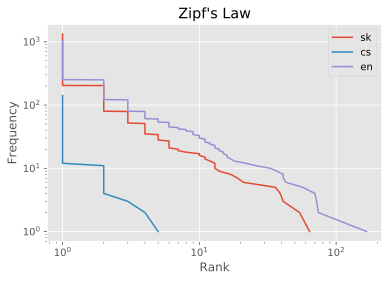

In [ ]:
do_law_of_zipf(data_raw)

# Data Cleaning and Preprocessing

In [ ]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    '''
    
    preprocessed_text = text.lower().replace('-',' ')
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    preprocessed_text = preprocessed_text.translate(translation_table)
    return preprocessed_text

In [ ]:
data_preprocessed = {k: [preprocess(sentence) for sentence in v]  for k,v in data_raw.items()}

In [ ]:
print('Raw')
show_statistics(data_raw)
print('\nPreprocessed')
show_statistics(data_preprocessed)

Raw
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...


Preprocessed
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1996
Number of unique words	:	 1207
Sample extract		:	 pán de grandes pascual jasne vysvetlil aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 155
Number of unique words	:	 133
Sample extract		:	 upozorňujeme že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentence

## Vectorizing Training Data

In [ ]:
sentences_train, y_train = [], []

for k, v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
X_train = vectorizer.fit_transform(sentences_train)

In [ ]:
X_train

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

## Initializing Model Parameters and Training

In [ ]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Vectorizing Validation Data and Evaluating Model

In [ ]:
data_val = dict()
data_val['sk'] = open_file('Data/Sentences/val_sentences.sk')
data_val['cs'] = open_file('Data/Sentences/val_sentences.cs')
data_val['en'] = open_file('Data/Sentences/val_sentences.en')

data_val_preprocessed = {k:[preprocess(sentence) for sentence in v] for k,v in data_val.items()}

In [ ]:
sentences_val, y_val = [], []

for k,v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [ ]:
x_val = vectorizer.transform(sentences_val)

In [ ]:
predictions = naive_classifier.predict(x_val)

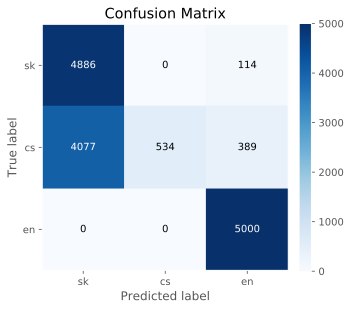

In [ ]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [ ]:
f1_score(y_val, predictions, average='weighted')

0.6149824401040264

# Hyperparameter tuning to improve model performance

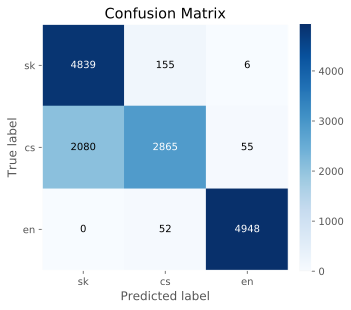

In [ ]:
naive_classifier = MultinomialNB(alpha=.0001, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(x_val)

plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [ ]:
f1_score(y_val, predictions, average='weighted')

0.8368507601649364

# Using Subwords to Shift Perspective and improve performance

In [ ]:
import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [ ]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [ ]:
vocab = get_vocab(sentences_train)

In [ ]:
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [ ]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [ ]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [ ]:
pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [ ]:
def split_into_subwords(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [ ]:
merge_ordered[:10]

['re', 'st', 'in', 'the', 'to', 'an', 'en', 'po', 'al', 'is']

In [ ]:
split_into_subwords('hello my name is rajat')

'lo na me is at ra'

In [ ]:
data_preprocessed_subwords = {k: [split_into_subwords(sentence) for sentence in v] for k,v in data_preprocessed.items()}

In [ ]:
show_statistics(data_preprocessed_subwords)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 3431
Number of unique words	:	 75
Sample extract		:	 de an de al as ne as...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 239
Number of unique words	:	 59
Sample extract		:	 po je me or že je le...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 3863
Number of unique words	:	 75
Sample extract		:	 an st an er ou ro ch...



In [ ]:
data_train_subwords = []
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [ ]:
data_val_subwords = []
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [ ]:
vectorizer = CountVectorizer()

In [ ]:
X_train = vectorizer.fit_transform(data_train_subwords)
X_val = vectorizer.transform(data_val_subwords)

In [ ]:
naive_classifier = MultinomialNB(alpha=1, fit_prior=False)
naive_classifier.fit(X_train, y_train)

predictions = naive_classifier.predict(X_val)

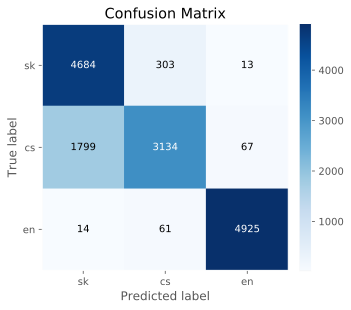

In [ ]:
plot_confusion_matrix(y_val, predictions, ['sk', 'cs', 'en'])

In [ ]:
f1_score(y_val, predictions, average='weighted')

0.8456381060126386